Código limpio para la tésis, se omite el analisis de caminantes aleaotrios

In [1]:
#from linkedin_api import Linkedin
import numpy as np
from bs4 import BeautifulSoup
import requests
import pandas as pd
import glob
import json
import uuid
import random
from faker import Faker
import networkx as nx
import itertools
import time
from networkx.algorithms import bipartite
import unicodedata
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib
import warnings
import seaborn as sns
from wonderwords import RandomWord
warnings.filterwarnings("ignore")
import scipy.stats as st
import imageio
import itertools

In [2]:
def add_edge(graph,df,period,columns,period_column):
    
    df = df[df[str(period_column)] == period][columns]
    df.drop(str(period_column), axis = 1, inplace = True)
    
    for edge in df.to_records(index=False):
        graph.add_edge(*edge)
        
    return graph

def define_graph_period(period, nodes, df,columns, period_colum = 'year'):
    _period = nx.Graph()
    for node in nodes:
        _period.add_node(node)
    _period = add_edge(_period, df, period,columns, period_colum)
    return _period

def proyection_bipartite(graph, year, list_,partition):
    _temp = bipartite.projected_graph(graph,partition)
    add  = (_temp,year)
    list_.append(add)
    return list_     

def bipartite_list(list_, projector):
    graphs_list_month_Rw = []
    for graph, year in list_:
        proyection_bipartite(graph, year, graphs_list_month_Rw,projector)
    return graphs_list_month_Rw

def k_average(graph_list):
    return [pd.DataFrame(nx.degree(value)).mean().values for value,key in graph_list]

def C_average(graph_list):
    return [np.array(list(nx.clustering(value).values())).mean() for value,key in graph_list]

def second_criteria(graphs_list_Rw):
    #Segundo Criterio
    for i in range(len(graphs_list_Rw)-1):
        for edge in graphs_list_Rw[i][0].edges():
            graphs_list_Rw[i+1][0].add_edge(*edge)
    return graphs_list_Rw

# Creamos las redes por mes

In [3]:
#Leemos los archivos
uuids = pd.read_csv('uuids merama.csv')
DF_to_adjacency_matrix_month = (pd.read_excel('DF_to_adjacency_matrix_month.xlsx',)
                                .sort_values(['uuid','period'])
                                .drop_duplicates())

#Seleccionamos los que esten en merama
DF_to_adjacency_matrix_month = (DF_to_adjacency_matrix_month[DF_to_adjacency_matrix_month
                                                             .uuid
                                                             .isin(uuids.uuid)]
                                .drop('industry', axis = 1))

In [4]:
# Tomamos todos los que tienen fecha arriba de 2010-01
DF_to_adjacency_matrix_month = DF_to_adjacency_matrix_month[(DF_to_adjacency_matrix_month.period >= '2010-01')]

In [5]:
#Primer intento agrupar y quedarnos solo con el primer trabajo
#NOTA ESTO GENERA PROBELMAS YA QUE ALGUNOS NO LES CONSIDERA MERAMA COMO SU PRIMER EMPRESA
#Existen 17 registros que su primera empresa no es MERAMA cuando tienen mas de una empresa registrada en el mismo periodo
#Representa el 4.4% de los empleados totales de MERAMA
#106861d3
#1ad566c3
#2db6de21
#31610b3d
#3e2b6653
#51497435
#5bd71dc6
#a1ee691a
#a4e0ee5b
#afdb4e0b
#bc39e1b3
#bf33551d
#c814ed3c
#eb6ec9e0
#efb80c63
#f3f05323
#f555a628
#En este punto podriamos considerar la distribucion de porbabilidad del historial del cambios 
DF_to_adjacency_matrix_month = DF_to_adjacency_matrix_month.groupby(['uuid','period']).first().reset_index()

In [6]:
#Seleccinamos todo lo mayor a 2010
graph = DF_to_adjacency_matrix_month[DF_to_adjacency_matrix_month.period >= '2010-01']

In [7]:
#Valores finales de parametros en las redes
print("Total personas", graph.uuid.nunique())
print("Total compañias", graph.company.nunique())
print("Total periodos", graph.period.nunique())

Total personas 386
Total compañias 772
Total periodos 155


In [8]:
386+772

1158

In [9]:
#Creamos los nodos
nodes = np.append(np.unique(graph.uuid),np.unique(graph.company))

In [10]:
#Creamos las red biparitita de forma mensual, NO considerando que las personas recuerdan las empresas donde han trabajado
columns = ['period','uuid','company']
years = []
graphs_list = []
for period in np.sort(graph.period.unique()):
    _temp = define_graph_period(period,nodes,graph,columns, period_colum = 'period')
    _period = str(period)
    years.append(period)
    add = (_temp,_period)
    graphs_list.append(add)

In [11]:
#Nombres para hacer las proyecciones
companys = graph.company.unique()
people = graph.uuid.unique()

In [12]:
#Proyeccion Companys
graphs_list_c_month = []
for graph, year in graphs_list:
    proyection_bipartite(graph, year, graphs_list_c_month,companys)

In [13]:
#Proyeccion Personas
graphs_list_p_month = []
for graph, year in graphs_list:
    proyection_bipartite(graph, year, graphs_list_p_month, people)

In [14]:
#Evolucion de la <k> y <C> k_average(graphs_list_c_month)
k_average_c_1_month  = k_average(graphs_list_c_month)
k_average_p_1_month  = k_average(graphs_list_p_month)
C_average_c_1_month  = C_average(graphs_list_c_month)
C_average_p_1_month  = C_average(graphs_list_p_month)

In [15]:
#Segundo Criterio
for i in range(len(graphs_list)-1):
    for edge in graphs_list[i][0].edges():
        graphs_list[i+1][0].add_edge(*edge)

In [16]:
#Proyeccion Companys 2
graphs_list_c_2_month = []
for graph, year in graphs_list:
    proyection_bipartite(graph, year, graphs_list_c_2_month,companys)

In [17]:
#Proyeccion personas 2
graphs_list_p_2_month = []
for graph, year in graphs_list:
    proyection_bipartite(graph, year, graphs_list_p_2_month, people)

In [18]:
#Evolucion de la <k> y <C>
k_average_c_2_month  = k_average(graphs_list_c_2_month)
k_average_p_2_month  = k_average(graphs_list_p_2_month)
C_average_c_2_month  = C_average(graphs_list_c_2_month)
C_average_p_2_month  = C_average(graphs_list_p_2_month)

# Histograma temporal de la red completa y proyecciones

In [33]:
#Neceistamos obetner la distirbucion de tamaños de los cumulos para cada instante de tiempo 

In [34]:
#Distribuciones de grado de la red completa en cada instante de tiempo 
def degree_distribution(graph_list):
    vals = []
    freq = []
    periods = []
    for i in range(len(graph_list)):
        vals_aux = pd.DataFrame(nx.degree(graph_list[i][0]))[1].value_counts().index
        freq_aux = pd.DataFrame(nx.degree(graph_list[i][0]))[1].value_counts().values
        period = graph_list[i][1]
        for val in vals_aux:
            vals.append(val)
        for val in freq_aux:
            freq.append(val)
        for j in range(len(freq_aux)):
            periods.append(period)
        
    return pd.DataFrame({'Ki':vals,
                        'freq':freq,
                        'period':periods})

def gif_image_generation(degree_distirbution_df, url):
    i = 0
    for period in degree_distirbution_df.period.unique():
        _aux = degree_distirbution_df[degree_distirbution_df.period == period]
        val = _aux.Ki
        freq = _aux.freq
        plt.loglog(val,freq,'.') #Linea para cambiar el tipo de grafica
        plt.title(period, size = 20)
        #plt.xlim(0, 369)
        plt.ylabel("Frecuencia", size = 20)
        plt.xlabel(r'$K_i$', size  = 20)
        plt.savefig(url + f'/img_{i}',bbox_inches = 'tight')
        plt.close()
        #plt.show()
        i+=1    

In [ ]:
degree_distirbution_complete = degree_distribution(graphs_list)#.groupby('period').sum()

In [ ]:
#Todo lo que tenga un K1 mayor a 16 lo vamos a agrupar en el mismo bin
degree_distirbution_complete['>16'] = np.where(degree_distirbution_complete.Ki > 16,1,0)

In [ ]:
degree_distirbution_complete.Ki = degree_distirbution_complete.Ki.astype('str')
degree_distirbution_complete.Ki = np.where(degree_distirbution_complete['>16'] == 1,
                                          '+17',
                                          degree_distirbution_complete.Ki)
degree_distirbution_complete = degree_distirbution_complete.groupby(['period','Ki']).sum().reset_index()

In [ ]:
degree_distirbution_complete['sort'] = degree_distirbution_complete['Ki'].str.extract('(\d+)', expand=False).astype(int)
degree_distirbution_complete.sort_values(['period','sort'],inplace=True, ascending=True)
degree_distirbution_complete = degree_distirbution_complete.drop('sort', axis=1)

In [ ]:
gif_image_generation(degree_distirbution_complete,'./images/Gif_distribucion_de_grado_red_completa')

In [ ]:
frames = []
for t in range(i):
    image = imageio.imread(f'./images/Gif_distribucion_de_grado_red_completa/img_{t}.png')
    frames.append(image)

In [ ]:
imageio.mimsave('./images/gif_cambios_distribucion_grado_red_completa.gif', 
                frames,         
                fps = 5)    

In [202]:
#CReamos ahora los gifs para la proyeccion sobre compañias
degree_distirbution_companys = degree_distribution(graphs_list_c_2_month)

gif_image_generation(degree_distirbution_companys,'./images/Gif_distribucion_de_grado_red_companys')

In [204]:
frames = []
for t in range(i):
    image = imageio.imread(f'./images/Gif_distribucion_de_grado_red_companys/img_{t}.png')
    frames.append(image)

imageio.mimsave('./images/gif_cambios_distribucion_grado_red_companys.gif',
                frames,        
                fps = 2)  

In [209]:
#CReamos ahora los gifs para la proyeccion sobre personas
degree_distirbution_personas = degree_distribution(graphs_list_p_2_month)

gif_image_generation(degree_distirbution_companys,'./images/Gif_distribucion_de_grado_red_people')

In [211]:
frames = []
for t in range(i):
    image = imageio.imread(f'./images/Gif_distribucion_de_grado_red_companys/img_{t}.png')
    frames.append(image)

imageio.mimsave('./images/gif_cambios_distribucion_grado_red_people.gif', 
                frames,      
                fps = 2)  

# Segumiento a los nodos influyentes personas

In [46]:
def node_tracing(graph_list, node):
    degrees = []
    nodes = []
    periods = []
    for i in range(len(graph_list)):
        degree = nx.degree(graph_list[i][0])[str(node)]
        degrees.append(degree)
        
        period = graph_list[i][1]
        periods.append(period)
        
        nodes.append(node)
    
    return pd.DataFrame({'node':nodes,
                         'period':periods,
                         'degree':degrees})   

def tracing_nodes_function(graph_list):
    tracing_nodes = pd.DataFrame()

    for node in val: #val
        _df = node_tracing(graph_list,  node)
        tracing_nodes = pd.concat([tracing_nodes,_df])
    return tracing_nodes

In [48]:
#¿Quienes son los nodos mas influyentes en el momento de formacion de Merama? 2020-10
element_k_p_2_a = graphs_list_p_2_month[131][0]
Gcc_k_p_2_a = sorted(nx.connected_components(element_k_p_2_a), key=len, reverse=True)
G0_k_p_2_a = element_k_p_2_a.subgraph(Gcc_k_p_2_a[0])
val = pd.DataFrame(nx.degree(G0_k_p_2_a)).sort_values(1).iloc[-10:][0]
freq = pd.DataFrame(nx.degree(G0_k_p_2_a)).sort_values(1).iloc[-10:][1]
dic = pd.read_excel('Consolidado_perfiles.xlsx').drop('Unnamed: 0', axis = 1)

In [49]:
#En este instante de tiempo, quienes tienen el grado mas alto

In [50]:
comparative = pd.DataFrame(nx.degree(element_k_p_2_a)).sort_values(1).iloc[-10:][0]

In [51]:
val = val.append(comparative).drop_duplicates()

In [52]:
#Agregamos a val los que ponen Merama en la fecha de fundacion

In [53]:
add = DF_to_adjacency_matrix_month[(DF_to_adjacency_matrix_month.company == 'Merama') & 
                                   (DF_to_adjacency_matrix_month.period == '2020-12')].uuid

In [54]:
#¿Quienes Son los primeros que ponen a Merama como su empresa?

In [55]:
dic[dic.uuid.isin(add)]

,id,name,headline,location,tags,url,uuid
131,eloycantu,Eloy Cantu,Corporate and Legal Affairs at Merama,Ciudad de México,MeramaEmployess,https://linkedin.com/in/eloycantu,f5657d00
147,felipedelgadom,Felipe Delgado,Co-Founder and CFO at Merama,"Colima, México",MeramaEmployess,https://linkedin.com/in/felipedelgadom,afb9f3a8
234,javier-blaustein-94312322,Javier Blaustein,Founding Team at Merama | Harvard Graduate,Ciudad de México,MeramaEmployess,https://linkedin.com/in/javier-blaustein-94312322,74f8c57b
452,sujaytyle,Sujay Tyle,Co-Founder and CEO at Merama | Venture Partner...,"Ciudad de México, México",MeramaEmployess,https://linkedin.com/in/sujaytyle,8625dcb0


In [56]:
val = val.append(add)
#val = val.drop(index = 12560)
val = val.drop_duplicates()

In [33]:
#Tomamos a partir de 2016-05 ya que es el primer mes donde los nodos tienen un grado mayor a cero
tracing_nodes = tracing_nodes_function(graphs_list_p_2_month)
tracing_nodes = tracing_nodes[(tracing_nodes.period >= '2016-04') & (tracing_nodes.period <= '2020-12')]

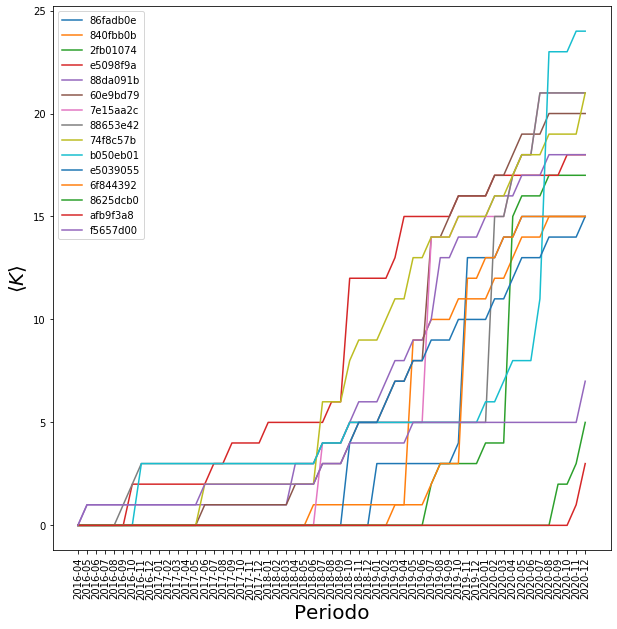

In [34]:
plt.figure(3,figsize=(10,10))
for node in tracing_nodes.node.unique():
    _df = tracing_nodes[tracing_nodes.node == node]
    plt.plot(_df.period, _df.degree, label = node)
plt.xticks(rotation = 90, fontsize = 10)
plt.xlabel('Periodo', size = 20)
plt.ylabel(r'$ K_i $', size =20)
plt.legend()
plt.show()

In [35]:
#¿Quienes son estas personas? ¿En donde han trabajado? ¿Se conocen? ¿De que trabajan?

In [36]:
#Historial de empleos
_df = DF_to_adjacency_matrix_month[DF_to_adjacency_matrix_month.uuid.isin(val)]

In [37]:
_timeline_employs = pd.pivot_table(_df, index = 'uuid', columns = 'period', values = 'company', aggfunc = 'first')

In [38]:
#¿Donde Han trabajado?
_timeline_employs.loc[:,'2020-12':]

period,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,...,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11
uuid,,,,,,,,,,,,,,,,,,,,,
2fb01074,Amazon,Amazon,Amazon,Amazon,Amazon,Amazon,Amazon,Amazon,Amazon,Amazon,...,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama
60e9bd79,Falabella,Falabella,Falabella,Falabella,Falabella,Falabella,Falabella,Merama,Merama,Merama,...,Merama,Merama,Merama,Merama,Merama,Merama,Merama,NaN,NaN,NaN
6f844392,MercadoLibre,MercadoLibre,MercadoLibre,MercadoLibre,Merama,Merama,Merama,Merama,Merama,Merama,...,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama
74f8c57b,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,...,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama
7e15aa2c,Amazon,Amazon,Amazon,Amazon,Amazon,Amazon,Amazon,Amazon,Amazon,Amazon,...,Amazon,Amazon,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama
840fbb0b,Amazon,Amazon,Amazon,Amazon,Amazon,Amazon,Merama,Merama,Merama,Merama,...,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama
8625dcb0,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,...,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama
86fadb0e,MercadoLibre,MercadoLibre,MercadoLibre,MercadoLibre,MercadoLibre,MercadoLibre,MercadoLibre,VALOREO,VALOREO,VALOREO,...,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama
88653e42,Amazon,Amazon,Amazon,Amazon,Merama,Merama,Merama,Merama,Merama,Merama,...,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama


In [39]:
#¿De que han trabajado?
titles = (pd.read_excel('Titles.xlsx')
          .rename(columns = {'companys':'company'})
          .drop_duplicates()
          .groupby(['uuid','company'])
          .first()
          .reset_index())

In [40]:
work_titles = pd.merge(_df, titles, on = ['uuid','company'], how = 'left')

In [41]:
#¿De que Han trabajado?
work_titles_timeline = pd.pivot_table(work_titles, index = 'uuid', columns = 'period', values = ['Titles'], aggfunc = 'first')

In [59]:
work_titles_timeline

Titles                              \
period                       2011-01                     2011-02   
uuid                                                               
2fb01074                         NaN                         NaN   
60e9bd79                         NaN                         NaN   
6f844392                         NaN                         NaN   
74f8c57b                         NaN                         NaN   
7e15aa2c                         NaN                         NaN   
840fbb0b                         NaN                         NaN   
8625dcb0  VP of Business Development  VP of Business Development   
86fadb0e                         NaN                         NaN   
88653e42                         NaN                         NaN   
88da091b                         NaN                         NaN   
afb9f3a8                         NaN                         NaN   
b050eb01                         NaN                         NaN   
e5039055                         NaN                         NaN   
e5098f9a                         NaN                         NaN   
f5657d00                         NaN                         NaN   

                                                                  \
period                       2011-03                     2011-04   
uuid                                                               
2fb01074                         NaN                         NaN   
60e9bd79                         NaN                         NaN   
6f844392                         NaN                         NaN   
74f8c57b                         NaN                         NaN   
7e15aa2c                         NaN                         NaN   
840fbb0b                         NaN                         NaN   
8625dcb0  VP of Business Development  VP of Business Development   
86fadb0e                         NaN                         NaN   
88653e42                         NaN                         NaN   
88da091b                         NaN                         NaN   
afb9f3a8                         NaN                         NaN   
b050eb01                         NaN                         NaN   
e5039055                         NaN                         NaN   
e5098f9a                         NaN                         NaN   
f5657d00                         NaN                         NaN   

                                                                  \
period                       2011-05                     2011-06   
uuid                                                               
2fb01074                         NaN                         NaN   
60e9bd79                         NaN                         NaN   
6f844392                         NaN                         NaN   
74f8c57b                         NaN                         NaN   
7e15aa2c                         NaN                         NaN   
840fbb0b                         NaN                         NaN   
8625dcb0  VP of Business Development  VP of Business Development   
86fadb0e                         NaN                         NaN   
88653e42                         NaN                         NaN   
88da091b                         NaN                         NaN   
afb9f3a8                         NaN                         NaN   
b050eb01                         NaN                         NaN   
e5039055                         NaN                         NaN   
e5098f9a                         NaN                         NaN   
f5657d00                         NaN                         NaN   

                                                                  \
period                       2011-07                     2011-08   
uuid                                                               
2fb01074                         NaN                         NaN   
60e9bd79                         NaN                         NaN   
6f844392       

In [57]:
val

70       840fbb0b
48       e5039055
62       2fb01074
94       e5098f9a
12       88da091b
31       60e9bd79
60       7e15aa2c
55       74f8c57b
105      88653e42
66       b050eb01
167      6f844392
14807    8625dcb0
17914    afb9f3a8
26088    f5657d00
dtype: object

In [54]:
#¿Se conocen?
nodes = []
periods = []
targets = []
for node in val:
    for period in range(len(graphs_list_p_2_month)):
        list_ = [neigbord for neigbord in graphs_list_p_2_month[period][0].neighbors(node)]
        for target in val:
            if target in list_:
                nodes.append(node)
                periods.append(graphs_list_p_2_month[period][1])
                targets.append(target)  

In [55]:
neighbords = (pd.DataFrame({'Node':nodes,'target':targets, 'period':periods})
             .sort_values('period')
             .groupby(['Node','target'])
             .first()
             .reset_index())

In [56]:
neighbords

,Node,target,period
0,00a1402e,00f24603,2022-04
1,00a1402e,01847803,2021-04
2,00a1402e,0262a5aa,2022-03
3,00a1402e,03927935,2022-03
4,00a1402e,039d60ba,2021-10
...,...,...,...
135871,ffbdfd47,fb2323e7,2022-05
135872,ffbdfd47,fb46ed39,2021-12
135873,ffbdfd47,fc145cfe,2022-04
135874,ffbdfd47,feeac13d,2022-05


In [61]:
#¿En que empresan trabajan cuando se conocieron?¿Cuantas conexiones tenian en esa fecha?

In [72]:
tracing_nodes = tracing_nodes_function(graphs_list_p_2_month)

In [73]:
neighbords = (pd.merge(neighbords, 
                       DF_to_adjacency_matrix_month, 
                       left_on = ['Node','period'], 
                       right_on = ['uuid', 'period'], 
                       how = 'left'))

In [74]:
neighbords = (pd.merge(neighbords,
              tracing_nodes,
              left_on = ['Node','period'],
              right_on = ['node','period'],
              how = 'left')).drop(['uuid','node'], axis = 1)

In [75]:
neighbords = (pd.merge(neighbords, 
              dic[['uuid','name','url']],
              left_on = 'Node',
              right_on = 'uuid',
              how = 'left')
    .drop('uuid',
          axis = 1))

In [50]:
pd.pivot_table(neighbords, index = 'Node', columns = 'target', values = 'company', aggfunc = 'first')

target,2fb01074,60e9bd79,6f844392,74f8c57b,7e15aa2c,840fbb0b,8625dcb0,86fadb0e,88653e42,88da091b,afb9f3a8,b050eb01,e5039055,e5098f9a,f5657d00
Node,,,,,,,,,,,,,,,
2fb01074,NaN,Amazon,Google,Amazon,Amazon,Amazon,Merama,Merama,Amazon,Google,Merama,Amazon,Amazon,Merama,Merama
60e9bd79,Falabella,NaN,Merama,Amazon,Falabella,Amazon,Merama,Merama,Falabella,Amazon,Merama,Falabella,Amazon,Merama,Merama
6f844392,OVGroup,Merama,NaN,Merama,Merama,Merama,Merama,MercadoLibre,Merama,OVGroup,Merama,Merama,Merama,Merama,Merama
74f8c57b,Amazon,Amazon,Merama,NaN,Amazon,Amazon,Merama,Merama,Amazon,Amazon,Merama,Amazon,Amazon,Merama,Uber
7e15aa2c,Amazon,Amazon,Merama,Amazon,NaN,Amazon,Merama,Merama,Procter&Gamble,Amazon,Merama,Procter&Gamble,Amazon,Merama,Merama
840fbb0b,Amazon,Amazon,Merama,Amazon,Amazon,NaN,Merama,Merama,Amazon,Amazon,Merama,Amazon,Amazon,Merama,Merama
8625dcb0,Merama,Merama,Merama,Merama,Merama,Merama,NaN,Merama,Merama,Merama,Merama,Merama,Merama,Merama,Merama
86fadb0e,Merama,Merama,MercadoLibre,Merama,Merama,Merama,Merama,NaN,Merama,Merama,Merama,Merama,Merama,Merama,Merama
88653e42,Amazon,Amazon,Merama,Amazon,GrupoHerdez,Amazon,Merama,Merama,NaN,Amazon,Merama,Procter&Gamble,Amazon,Merama,Merama


In [27]:
#neighbords.groupby('Node').first()[['name','url']][0]

# Distribuciones de probabilidad del "Palacanzo"
## Fecha Critica 2020-12 numero 131

In [19]:
def nodes_neighbords_dfs(val, 
                         graph_list = graphs_list_p_2_month, 
                         DF_to_adjacency_matrix_month = DF_to_adjacency_matrix_month,
                        ):
    #¿Se conocen?
    nodes = []
    periods = []
    targets = []
    for node in val:
        for period in range(len(graph_list)):
            list_ = [neigbord for neigbord in graph_list[period][0].neighbors(node)]
            for target in val:
                if target in list_:
                    nodes.append(node)
                    periods.append(graph_list[period][1])
                    targets.append(target)  
    
    neighbords = (pd.DataFrame({'Node':nodes,'target':targets, 'period':periods})
             .sort_values('period')
             .groupby(['Node','target'])
             .first()
             .reset_index())
    
    neighbords = (pd.merge(neighbords, 
                       DF_to_adjacency_matrix_month, 
                       left_on = ['Node','period'], 
                       right_on = ['uuid', 'period'], 
                       how = 'left'))
    
    tracing_nodes = tracing_nodes_function(graph_list)
    
    neighbords = (pd.merge(neighbords,
                  tracing_nodes,
                  left_on = ['Node','period'],
                  right_on = ['node','period'],
                  how = 'left')).drop(['uuid','node'], axis = 1)
    
    
    return neighbords

In [20]:
#Mapeamos los periodos de fechas a numeros para hacerlos mas facil de manejar
sort_dates = (pd.to_datetime(DF_to_adjacency_matrix_month.period.unique(), format = '%Y-%m' )
              .sort_values()
              .strftime('%Y-%m'))
t = 0
tuples = []
for period in sort_dates:
    tuples.append((period,t))
    t += 1

dates_map = {key:value for key,value in tuples}

In [21]:
DF_to_adjacency_matrix_month['period_num'] = DF_to_adjacency_matrix_month.period.map(dates_map)

In [22]:
#Vemos cuantas compañias tenian mas de un empleado a cierto periodo 
counts = DF_to_adjacency_matrix_month.groupby(['period','company'])['uuid'].nunique().reset_index()

In [23]:
companys = counts[counts.uuid > 1].company.unique()

In [24]:
#Agrupamos por periodo y compañia y sacamos los unicos
gruped_df = DF_to_adjacency_matrix_month.groupby(['period_num','company'])['uuid'].unique().reset_index()
gruped_df['count'] = gruped_df.uuid.apply(lambda x: len(x))

In [25]:
gruped_df = gruped_df[(gruped_df.company.isin(companys)) & (gruped_df.period_num <= 131)]

In [43]:
#Experimentos

In [29]:
# Todos los posibles empleados
val = DF_to_adjacency_matrix_month.uuid.unique()

In [56]:
#Creamos el conjunto de todas las posibles combinaciones de 2 elementos
conjunto_total = set(itertools.combinations(val, 2))

#Generamos los conjuntos de parejas para cada empresa el tiempo en el DF agrupado
gruped_df['sets'] = gruped_df.uuid.apply(lambda x: set(itertools.combinations(x, 2)))

#Contamos cuantos sets tiene cada fila
gruped_df['number_of_subsets'] = gruped_df['sets'].apply(lambda x: len(x))

#Contamos cuantos interseccionan con el conjunto total
gruped_df['number_of_intersection'] = gruped_df['sets'].apply(lambda x: len(x.intersection(conjunto_total)))

#Vericamos que number_of_subsets sea igual a number_of_instersecction
print((gruped_df['number_of_subsets'] == gruped_df['number_of_intersection']).value_counts())

#COn este conteo verificamos que cada subsets este dentro del total posible de sets de dos elementos con todos los 
#empleados analizados

()

In [62]:
#Verificamos de los subsets totales cuales son subsets de los guardados para cada compañia en cada instante de tiempo
subsets = []
period_num = []
companys = []
for subset_total in conjunto_total:
    for index, value in gruped_df.iterrows():
        if subset_total in value.sets:
            subsets.append(subset_total)
            period_num.append(value.period_num)
            companys.append(value.company)

In [63]:
#CReamos el DataFrame con el resultado
pd.DataFrame({'subsets': subsets, 'period_num': period_num, ' companys': companys})

,subsets,period_num,companys
0,"(2fb01074, a9c7ae92)",123,Amazon
1,"(2fb01074, a9c7ae92)",124,Amazon
2,"(2fb01074, a9c7ae92)",125,Amazon
3,"(2fb01074, a9c7ae92)",126,Amazon
4,"(2fb01074, a9c7ae92)",127,Amazon
...,...,...,...
6565,"(60e9bd79, 74f8c57b)",108,Amazon
6566,"(60e9bd79, 74f8c57b)",109,Amazon
6567,"(60e9bd79, 74f8c57b)",110,Amazon
6568,"(60e9bd79, 74f8c57b)",111,Amazon


In [64]:
pd.DataFrame({'subsets': subsets, 'period_num': period_num, ' companys': companys}).to_csv('subsets_df.csv')

In [54]:
gruped_df['sets'].apply(lambda x: len(x.intersection(conjunto_total)))

7        0
8        0
26       0
27       0
46       0
        ..
15801    6
15806    6
15807    1
15810    0
15812    3
Name: sets, Length: 3487, dtype: int64

In [52]:
gruped_df['sets'][15806]

{('067fece7', '2266a107'),
 ('067fece7', '40709bd4'),
 ('067fece7', '9c63765b'),
 ('2266a107', '40709bd4'),
 ('2266a107', '9c63765b'),
 ('40709bd4', '9c63765b')}

In [41]:
for tuple_ in conjunto_total:
    print(type(tuple_))
    break

<class 'tuple'>


In [49]:
gruped_df['sets'][15801]

{('c9d0a7f4', 'ed3032ed'),
 ('c9d0a7f4', 'f172840f'),
 ('c9d0a7f4', 'f902d6c0'),
 ('ed3032ed', 'f172840f'),
 ('ed3032ed', 'f902d6c0'),
 ('f172840f', 'f902d6c0')}

In [48]:
gruped_df['sets'][15801].intersection(conjunto_total)

{('c9d0a7f4', 'ed3032ed'),
 ('c9d0a7f4', 'f172840f'),
 ('c9d0a7f4', 'f902d6c0'),
 ('ed3032ed', 'f172840f'),
 ('ed3032ed', 'f902d6c0'),
 ('f172840f', 'f902d6c0')}

In [42]:
conjunto_total

{('a1ee691a', 'e08c28eb'),
 ('1d8ac1a9', 'a9584453'),
 ('3a8be161', 'fb2323e7'),
 ('59c07423', 'e4d08ebe'),
 ('5d005716', 'c5826444'),
 ('627b9de7', 'c30759a4'),
 ('72e6316e', 'cc68fd3f'),
 ('83210210', 'e998952c'),
 ('22d80170', 'bc39e1b3'),
 ('4bebcf4f', 'c095e099'),
 ('53e83663', 'f367dbe2'),
 ('2fb01074', '567fec5e'),
 ('0dbcad25', 'e65a3ae4'),
 ('20e30a4d', 'd2d07223'),
 ('9cc753ad', 'a1d33772'),
 ('627b9de7', '69083bd6'),
 ('06714938', '820bc51d'),
 ('31cb5e8e', '3fb230b2'),
 ('1903b45f', 'e963544a'),
 ('06999e1e', '437249fd'),
 ('24eac3f4', 'd61a43f2'),
 ('2e22fd39', 'a9584453'),
 ('28b74f3d', 'f1c51dda'),
 ('50eaa1d2', 'f555a628'),
 ('907d8532', 'c81236e6'),
 ('b56b9357', 'e4d08ebe'),
 ('40e5e8fa', '9c63765b'),
 ('5ba48aa0', '68adc28f'),
 ('65578e91', 'e51c0cdb'),
 ('4598244b', '7751b3fa'),
 ('59de5319', 'af3b5a91'),
 ('4202faf9', 'e1a9344e'),
 ('91fd7d4a', 'ac825818'),
 ('ca6ef7ce', 'd8a1a546'),
 ('ca6ef7ce', 'de386aeb'),
 ('3d7439ee', '840fbb0b'),
 ('2449213a', 'b75db71e'),
 

In [34]:
len(val)

386

In [37]:
386*386

148996

In [26]:
gruped_df['sets'] = gruped_df.uuid.apply(lambda x: set(itertools.combinations(x, 2)))

In [105]:
if set([('f902d6c0', 'f172840f')]).issubset(gruped_df.loc[15801].sets):
    print('yes')
else:
    print('no')

no


In [107]:
set([('c9d0a7f4', 'ed3032ed')]).issubset(gruped_df.loc[15801].sets)

True

In [102]:
gruped_df.loc[15801].sets

{('c9d0a7f4', 'ed3032ed'),
 ('c9d0a7f4', 'f172840f'),
 ('c9d0a7f4', 'f902d6c0'),
 ('ed3032ed', 'f172840f'),
 ('ed3032ed', 'f902d6c0'),
 ('f172840f', 'f902d6c0')}

In [110]:
set([('f172840f', 'f902d6c0')]) == set([('f902d6c0', 'f172840f')])

False

In [ ]:
uuids
for uuid in val:
    for period in gruped_df.perid_num:
        _df = gruped_df[gruped_df.period_num == period]
        for company in _df.company:
            _df_2 = _df[_df.company == company]
            for target in _df_2.uuid:
                if uuid in target:
                    

In [74]:
['c9d0a7f4', 'ed3032ed'] in set([['c9d0a7f4', 'ed3032ed'], ['f172840f', 'f902d6c0']])

TypeError: unhashable type: 'list'

In [69]:
for uuid in gruped_df.uuid:
    print(uuid)

['5d005716']
['4598244b']
['5d005716']
['4598244b']
['5d005716']
['4598244b']
['5d005716']
['4598244b']
['5d005716']
['4598244b']
['5d005716']
['4598244b']
['5d005716']
['4598244b']
['5d005716']
['4598244b']
['5d005716']
['4598244b']
['5d005716']
['4598244b']
['5d005716']
['4598244b']
['5d005716']
['4598244b']
['5d005716']
['4598244b']
['5d005716']
['4598244b']
['5d005716']
['4598244b']
['60c8e5a0']
['5d005716']
['4598244b']
['60c8e5a0']
['5d005716']
['4598244b']
['60c8e5a0']
['5d005716']
['4598244b']
['60c8e5a0']
['5d005716']
['4598244b']
['6409df32']
['60c8e5a0']
['5d005716']
['4598244b']
['6409df32']
['60c8e5a0']
['5d005716']
['4598244b']
['1a9e8547']
['6409df32']
['60c8e5a0']
['5d005716']
['4598244b']
['1a608f0d' '1a9e8547']
['6409df32']
['60c8e5a0']
['5d005716' 'd7604342']
['4598244b']
['1a608f0d' '1a9e8547']
['6409df32']
['60c8e5a0']
['5d005716' 'd7604342']
['4598244b']
['1a608f0d' '1a9e8547']
['6409df32']
['60c8e5a0']
['5d005716' 'd7604342' 'e4d08ebe']
['4598244b']
['1a608f0d' '

In [59]:
gruped_df

,period_num,company,uuid,count
7,0,Deloitte,[5d005716],1
8,0,EnelGreenPower,[4598244b],1
26,1,Deloitte,[5d005716],1
27,1,EnelGreenPower,[4598244b],1
46,2,Deloitte,[5d005716],1
...,...,...,...,...
15801,131,Walmart,"[c9d0a7f4, ed3032ed, f172840f, f902d6c0]",4
15806,131,XPInc.,"[067fece7, 2266a107, 40709bd4, 9c63765b]",4
15807,131,YaraInternational,"[1480f037, 3008a519]",2
15810,131,adidas,[edfda291],1


In [65]:
DF_to_adjacency_matrix_month[(DF_to_adjacency_matrix_month.period_num == 131) & (DF_to_adjacency_matrix_month.company =='Walmart')]

,uuid,period,company,period_num
20831,c9d0a7f4,2020-12,Walmart,131
24593,ed3032ed,2020-12,Walmart,131
25421,f172840f,2020-12,Walmart,131
26212,f902d6c0,2020-12,Walmart,131


In [44]:
val = DF_to_adjacency_matrix_month.uuid.unique()

In [47]:
nodes_neighbords_dfs(val)

,Node,target,period,company,period_num,degree
0,00a1402e,00f24603,2022-04,EGADEBusinessSchooldelTecnologicodeMonterrey,147.0,228
1,00a1402e,01847803,2021-04,Merama,135.0,33
2,00a1402e,0262a5aa,2022-03,EGADEBusinessSchooldelTecnologicodeMonterrey,146.0,204
3,00a1402e,03927935,2022-03,EGADEBusinessSchooldelTecnologicodeMonterrey,146.0,204
4,00a1402e,039d60ba,2021-10,FibraEco,141.0,124
...,...,...,...,...,...,...
135871,ffbdfd47,fb2323e7,2022-05,Merama,148.0,270
135872,ffbdfd47,fb46ed39,2021-12,Merama,143.0,154
135873,ffbdfd47,fc145cfe,2022-04,Merama,147.0,228
135874,ffbdfd47,feeac13d,2022-05,Merama,148.0,270


In [58]:
DF_to_adjacency_matrix_month[DF_to_adjacency_matrix_month.uuid == '00f24603']

,uuid,period,company,period_num
56,00f24603,2018-02,YvesRocher,97
57,00f24603,2018-03,YvesRocher,98
58,00f24603,2018-04,YvesRocher,99
59,00f24603,2018-05,YvesRocher,100
60,00f24603,2018-06,YvesRocher,101
61,00f24603,2018-07,YvesRocher,102
62,00f24603,2018-08,YvesRocher,103
63,00f24603,2018-09,YvesRocher,104
64,00f24603,2018-10,YvesRocher,105
65,00f24603,2018-11,YvesRocher,106


In [49]:
DF_to_adjacency_matrix_month[DF_to_adjacency_matrix_month.uuid == '00a1402e']

,uuid,period,company,period_num
0,00a1402e,2018-04,Facebook,99
1,00a1402e,2018-05,Facebook,100
2,00a1402e,2018-06,Facebook,101
3,00a1402e,2018-07,Facebook,102
4,00a1402e,2018-08,Facebook,103
5,00a1402e,2018-09,Facebook,104
6,00a1402e,2018-10,Facebook,105
7,00a1402e,2018-11,Facebook,106
8,00a1402e,2018-12,Facebook,107
9,00a1402e,2019-01,Facebook,108


In [44]:
pd.pivot_table(exp_1, index = 'uuid', columns = 'uuid', values = 'period_num', aggfunc = 'first')

ValueError: Grouper for 'uuid' not 1-dimensional

In [45]:
DF_to_adjacency_matrix_month

,uuid,period,company,period_num,uuid_2
0,00a1402e,2018-04,Facebook,99,00a1402e
1,00a1402e,2018-05,Facebook,100,00a1402e
2,00a1402e,2018-06,Facebook,101,00a1402e
3,00a1402e,2018-07,Facebook,102,00a1402e
4,00a1402e,2018-08,Facebook,103,00a1402e
...,...,...,...,...,...
27044,ffbdfd47,2022-07,Merama,150,ffbdfd47
27045,ffbdfd47,2022-08,Merama,151,ffbdfd47
27046,ffbdfd47,2022-09,Merama,152,ffbdfd47
27047,ffbdfd47,2022-10,Merama,153,ffbdfd47


In [39]:
DF_to_adjacency_matrix_month[DF_to_adjacency_matrix_month.period_num == 10]

,uuid,period,company,period_num
124,01847803,2010-11,BDO,10
1793,1932263c,2010-11,RoblesTostadoCoronaySanchezGilS.C.,10
2126,1a608f0d,2010-11,EscritoriodeContabilidadeBenettiS/CLtda,10
2350,1a9e8547,2010-11,McLanedoBrasil,10
3114,1f69cd43,2010-11,OdebrechtEngenhariaeConstrucao,10
3683,23aa9e67,2010-11,ProduccionesSonivC.A.,10
6677,3e2b6653,2010-11,GE,10
7518,4598244b,2010-11,EnelGreenPower,10
7673,47e77e2b,2010-11,SaoPauloAirwaysComissariadeDespachosLtda.,10
9052,540988e7,2010-11,AdvocaciaCarlosGoulart,10


In [35]:
gruped_df#[gruped_df['count'] == 13]

,period_num,company,uuid,count
7,0,Deloitte,[5d005716],1
8,0,EnelGreenPower,[4598244b],1
26,1,Deloitte,[5d005716],1
27,1,EnelGreenPower,[4598244b],1
46,2,Deloitte,[5d005716],1
...,...,...,...,...
15801,131,Walmart,"[c9d0a7f4, ed3032ed, f172840f, f902d6c0]",4
15806,131,XPInc.,"[067fece7, 2266a107, 40709bd4, 9c63765b]",4
15807,131,YaraInternational,"[1480f037, 3008a519]",2
15810,131,adidas,[edfda291],1


In [38]:
gruped_df[gruped_df.period_num == 50]

,period_num,company,uuid,count
1830,50,AT&T,[f0041e32],1
1836,50,BaldertonCapital,[106861d3],1
1839,50,Braskem,[1f6ceec1],1
1844,50,CencosudS.A.,[60c8e5a0],1
1846,50,Concentric,[2db6de21],1
1849,50,DecathlonBrasil,[f367dbe2],1
1850,50,Deloitte,"[5d005716, af3b5a91, d7604342, e4d08ebe]",4
1852,50,EY,[5c6be596],1
1854,50,EnelGreenPower,[4598244b],1
1867,50,JonesDay,[1932263c],1


# Segumiento a los nodos influyentes empresas

In [295]:
element_k_c_2_a = graphs_list_c_2_month[131][0]
Gcc_k_c_2_a = sorted(nx.connected_components(element_k_c_2_a), key=len, reverse=True)
G0_k_c_2_a = element_k_c_2_a.subgraph(Gcc_k_p_2_a[0])
val = pd.DataFrame(nx.degree(G0_k_c_2_a)).sort_values(1).iloc[-10:][0]
freq = pd.DataFrame(nx.degree(G0_k_c_2_a)).sort_values(1).iloc[-10:][1]
#dic = pd.read_excel('Consolidado_perfiles.xlsx').drop('Unnamed: 0', axis = 1)

KeyError: 1

In [296]:
G0_k_c_2_a

In [1]:
import numpy as np

In [3]:
sizes = [2, 3, 1]

In [4]:
[np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

[array([[-1.11916542,  0.26398547],
        [-0.79451144,  0.03949404],
        [-1.98493355, -0.98290354]]),
 array([[-0.11936453,  0.36320046,  0.20732349]])]

In [5]:
[np.random.randn(y, 1) for y in sizes[1:]]

[array([[ 0.83768833],
        [ 0.37571614],
        [-0.33142527]]),
 array([[-0.2546713]])]

In [6]:
class Network(object):

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(sizes[:-1], sizes[1:])]
        
    def feedforward(self, a):
    """Return the output of the network if "a" is input."""
        
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        
         return a
        
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))



In [7]:
net = Network([2, 3, 1])


In [10]:
net.weights

[array([[ 0.06448947, -0.32933985],
        [ 0.70564994, -0.43538737],
        [ 1.02595965,  0.05092965]]),
 array([[-1.63950985,  2.39076991, -1.30020674]])]

In [12]:
test_results = [(x,y) for x in range(3) for y in range (3)]

In [13]:
test_results

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [16]:
[int(x == y) for (x, y) in test_results]

[1, 0, 0, 0, 1, 0, 0, 0, 1]